## KNN Approach



### Setup

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets

from pathlib import Path
import os

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler


from pyMLaux import plot_history, evaluate_classification_result,plot_2d_prediction


2024-05-06 20:57:22.263776: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-06 20:57:22.331204: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 20:57:22.331247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 20:57:22.332605: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-06 20:57:22.344228: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# read dynamic path
base_dir = Path(os.getcwd())/"implementation"
data_dir = base_dir / "data/source/"
result_dir = base_dir / "data/results/"

### load & prepare dataset

the following code needs to be adapted for each protein-ligand complex individually

In [3]:
nn_data_raw = pd.read_csv(data_dir/"ACHE/ache_pca.csv")

nn_data_raw

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,21,22,23,24,25,26,27,28,29,LABEL
0,0,2.775103,1.569092,-1.633093,0.509205,-0.365362,0.464463,-1.344698,0.340212,1.195709,...,-0.426203,0.157809,-0.384176,-0.775244,-0.265311,0.172972,-0.078754,0.175435,0.157472,active
1,1,1.160143,0.745342,3.626592,-0.482753,-0.501234,-0.702610,0.148980,1.191717,-0.315544,...,-0.197789,-0.733598,0.058455,0.356964,0.004727,0.491466,0.056198,-0.304857,0.442595,active
2,2,1.347487,-1.066134,0.930806,-0.326445,1.909936,0.292744,0.015491,0.427259,0.980201,...,-0.371311,-0.441166,-0.295813,0.288092,-0.258665,-0.158248,0.097048,-0.130219,-0.302125,active
3,3,4.217589,-0.574677,1.399565,1.361755,-1.065899,0.487160,0.041603,0.652388,0.670705,...,-0.035638,0.009457,0.003479,0.175791,0.480889,-0.397306,-0.118256,-0.429759,0.046488,active
4,4,2.269227,-0.097871,0.590080,0.325115,1.649822,0.056987,-0.778049,0.349009,0.760214,...,-0.450115,-0.645917,0.283596,-0.353558,-0.340660,0.206826,-0.132083,-0.185250,0.394408,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,998,-0.609818,-0.656158,-0.131409,0.554176,-0.437736,-0.673396,-0.254374,-0.307080,-0.299093,...,0.298212,0.244026,0.018224,0.040865,-0.106602,0.218396,-0.221769,0.094682,0.076756,active
999,999,-0.418320,-0.805650,-0.109816,-0.376300,-0.549992,-0.458199,0.583562,0.367584,0.043453,...,-0.381802,0.069187,-0.053126,0.357976,0.090901,0.410654,-0.183452,0.216238,-0.213667,active
1000,1000,-1.637342,-0.955758,0.168724,0.684614,-0.258857,-0.898800,0.085315,0.578703,0.398927,...,0.703583,0.167216,-0.588820,-0.750097,-0.244467,0.106357,-0.130821,0.226009,-0.169840,active
1001,1001,0.573375,-0.944395,-0.090789,-0.004957,-0.256222,-0.095932,0.025505,-0.122203,0.328594,...,0.046983,0.173622,-0.314616,-0.280141,-0.116199,0.507827,-0.063389,0.449591,-0.264470,inactive


In [4]:
lookup = {'inactive':0,'active':1}

nn_data = {'data': np.array(nn_data_raw.iloc[:, 2:-1]),
             'target': np.array([lookup[y] for y in nn_data_raw.iloc[0:,-1]]),
             'feature_names': nn_data_raw.columns[2:-1],
             'target_names': ['inactive', 'active']}


split into train- and test-set

In [5]:
X_train, X_test, y_train, y_test = train_test_split(nn_data['data'], nn_data['target'],
                                                    test_size=0.3, random_state=4232)



### train and apply neural network

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(nn_data['data'].shape[1], )),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 30        
                                                                 
Total params: 30 (120.00 Byte)
Trainable params: 30 (120.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-05-06 20:57:25.002084: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-06 20:57:25.033662: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-06 20:57:25.033735: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-06 20:57:25.037360: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-06 20:57:25.037438: I external/local_xla/xla/stream_executor

Epoch 1/150


2024-05-06 20:57:25.951324: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-06 20:57:26.313815: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8e5d56ef70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-06 20:57:26.313851: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-05-06 20:57:26.318431: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-06 20:57:26.333651: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1715021846.409073   11158 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


36/36 - 1s - loss: 0.8396 - accuracy: 0.4278 - val_loss: 0.7436 - val_accuracy: 0.4539 - 1s/epoch - 40ms/step
Epoch 2/150
36/36 - 0s - loss: 0.8181 - accuracy: 0.4367 - val_loss: 0.7299 - val_accuracy: 0.4823 - 201ms/epoch - 6ms/step
Epoch 3/150
36/36 - 0s - loss: 0.7992 - accuracy: 0.4652 - val_loss: 0.7182 - val_accuracy: 0.4894 - 218ms/epoch - 6ms/step
Epoch 4/150
36/36 - 0s - loss: 0.7820 - accuracy: 0.4884 - val_loss: 0.7070 - val_accuracy: 0.5035 - 206ms/epoch - 6ms/step
Epoch 5/150
36/36 - 0s - loss: 0.7658 - accuracy: 0.5027 - val_loss: 0.6957 - val_accuracy: 0.5248 - 187ms/epoch - 5ms/step
Epoch 6/150
36/36 - 0s - loss: 0.7499 - accuracy: 0.5169 - val_loss: 0.6856 - val_accuracy: 0.5461 - 186ms/epoch - 5ms/step
Epoch 7/150
36/36 - 0s - loss: 0.7351 - accuracy: 0.5276 - val_loss: 0.6761 - val_accuracy: 0.5603 - 205ms/epoch - 6ms/step
Epoch 8/150
36/36 - 0s - loss: 0.7207 - accuracy: 0.5472 - val_loss: 0.6661 - val_accuracy: 0.5674 - 194ms/epoch - 5ms/step
Epoch 9/150
36/36 - 0s

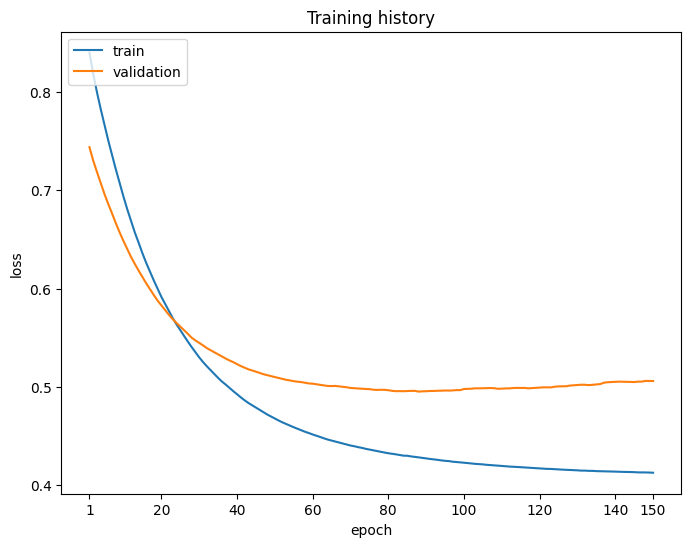

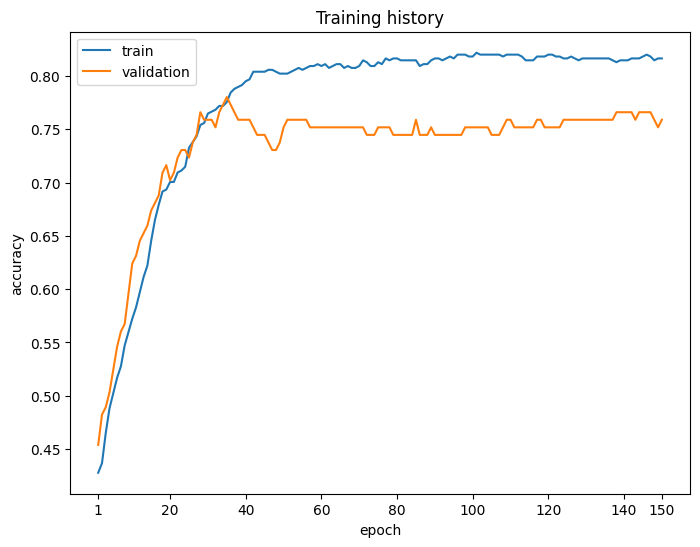

In [7]:
history = model.fit(x=X_train, y=y_train, epochs=150, batch_size=16, validation_split=0.2, verbose=2)
plot_history(history)

In [10]:
df = pd.read_csv(result_dir/"ACHE/val/ache_val.csv",sep=",",index_col="Index")
df.loc[len(df["Name"])] = ["fe_pca_nn",0.7589]
df.to_csv(result_dir/"ACHE/val/ache_val.csv",sep=",",index="Index")

### Evaluate Testdata using model

In [8]:
pred = model.predict(X_test)
classes= [1 if i > 0.5  else 0 for i in pred]


10/10 [==============================] - 0s 2ms/step


### Prepare Data for evaluation

In [9]:
result_df = pd.DataFrame(columns=nn_data_raw.columns[:-1])

for i, row in enumerate(X_test):
    data = [i,i]
    data.extend(row)
    result_df.loc[i+1] = data

result_df["LABEL"] = y_test
result_df["PRED"] = classes

result_df.to_csv(result_dir / "ACHE/fe_pca_nn.csv", encoding="utf-8")